In [3]:
# パッケージ
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, SimpleRNN, GRU
from keras import optimizers
from keras.callbacks import EarlyStopping

In [4]:
target_data = pd.read_csv("./target/target_USDJPY.csv")
#----OPTIONS----
unitsRNN      = 240
learning_rate = 0.0001
patience      = 10
epochs        = 2000
batch_size    = 30
maxlen = 240

In [5]:
'''
1. データの準備
'''

x = [target_data["deviation_rate"][i:i+maxlen].values for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen)]
# x = []
# for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen):
#     d = []
#     h = []
#     l = []
#     for j in range(maxlen):
#         d.append(target_data["deviation_rate"].values[i+j])
#         h.append(target_data["high"].values[i+j]/target_data["open"].values[i+j])
#         l.append(target_data["low"].values[i+j]/target_data["open"].values[i+j])
#     ilist = pd.DataFrame(data={
#         "deviation_rate": d,
#         "high": h,
#         "low": l
#     })
    # x.append(ilist)
t = [ target_data["rise_rate"][i+maxlen-1] for i in range(59, len(target_data["rise_rate"].values[:])-maxlen)]

x = np.array(x).reshape(-1, maxlen, 1)
t = np.array(t).reshape(-1, 1)
print(x.shape, t.shape)

x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.2, shuffle=False)

(51426, 240, 1) (51426, 1)


In [6]:
'''
2. モデルの構築
'''
model = Sequential()
model.add(LSTM(unitsRNN, activation='tanh',
                recurrent_activation='sigmoid',
                kernel_initializer='he_normal',
                recurrent_initializer='orthogonal'))
model.add(Dense(120, activation='linear'))
model.add(Dense(1, activation='linear'))
model.add(Activation('tanh'))

In [7]:
'''
3. モデルの学習
'''
optimizer = optimizers.Adam(learning_rate=learning_rate,
                              beta_1=0.9, beta_2=0.999, amsgrad=True)

model.compile(optimizer=optimizer,
            loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',
                patience=patience,
                verbose=1)

hist = model.fit(x_train, t_train,
                epochs=epochs, batch_size=batch_size,
                verbose=2,
                validation_data=(x_val, t_val),callbacks=[es])

Epoch 1/2000


2023-06-07 22:09:40.543949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 22:09:40.545495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 22:09:40.546553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1372/1372 - 283s - loss: 1.0069 - val_loss: 0.9843 - 283s/epoch - 206ms/step
Epoch 2/2000
1372/1372 - 203s - loss: 0.9948 - val_loss: 0.9862 - 203s/epoch - 148ms/step
Epoch 3/2000


 11/563 [..............................] - ETA: 5s

2023-06-04 14:28:30.304937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-04 14:28:30.306642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-04 14:28:30.307513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

563/563 [==============================] - 6s 10ms/step


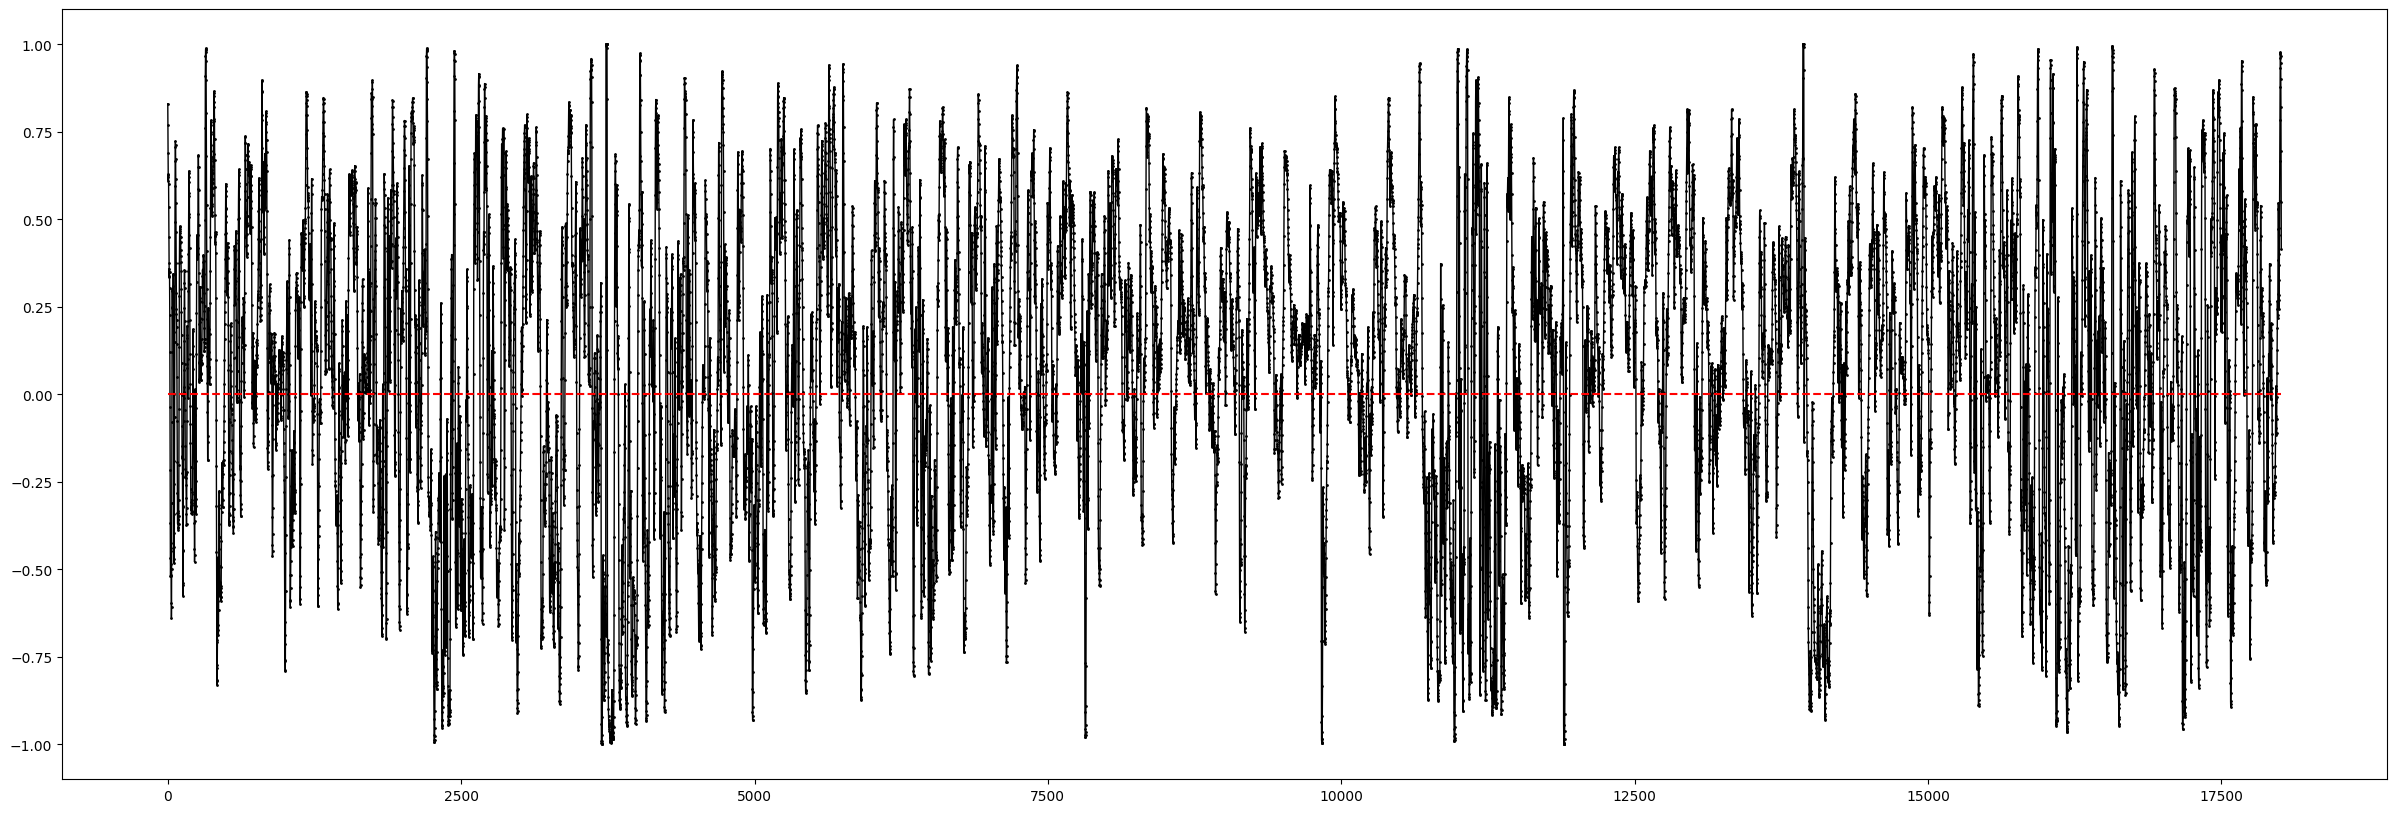

In [ ]:
'''
4. モデルの評価
'''
indata = t
predicted = []

preds = model.predict(x)
for i in range(len(preds)):
    predicted.append(preds[i])

# 予測値を可視化
fig = plt.figure(figsize=(30, 10))
plot_length = len(predicted)
plt.plot(range(plot_length), predicted[:plot_length],
        color='black', linewidth=1,
        marker='o', markersize=1, markerfacecolor='black',
        markeredgecolor='black')
plt.plot([0, plot_length],[0, 0], "red", linestyle='dashed')
plt.show()

In [ ]:
len(predicted)

18012

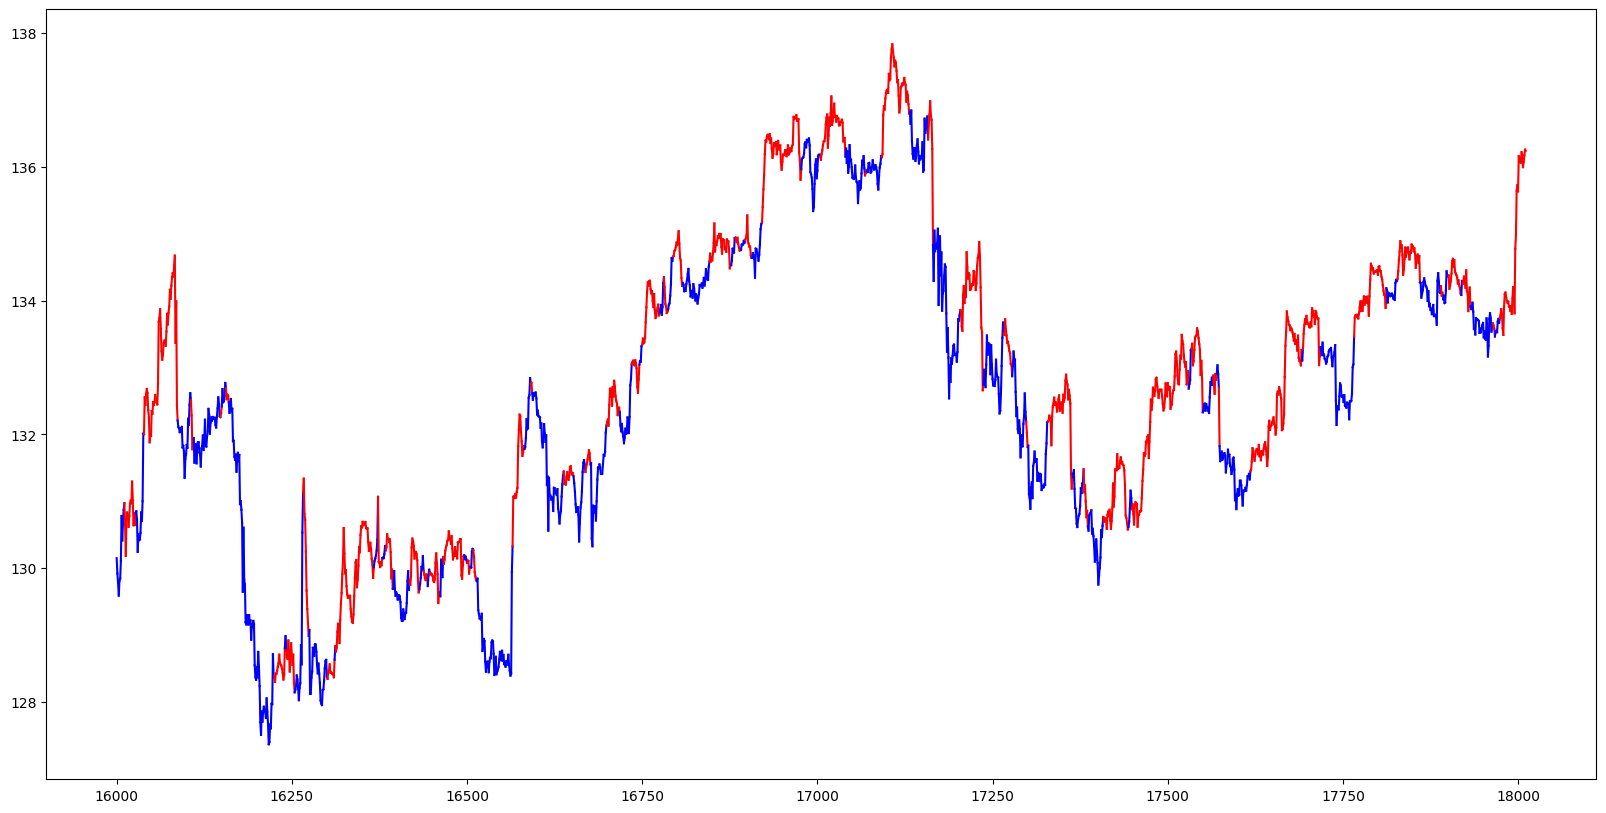

In [ ]:
# 実データに反映し描画
chart = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
fig = plt.figure(figsize=(20,10))
plot_length = len(chart)
for i in range(16000,plot_length-1):
    plt.plot(range(plot_length+1)[i:i+2], chart[i:i+2], color= 'red' if predicted[i] > 0 else 'blue')
plt.show()

In [ ]:
# 売買シミュレーション
#---OPTIONS---
chart = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
predicted = [1]*len(chart)
total   = 100000     # 初期金額
per     = 0.1       # 1回の投資金額
per_lot = 100000     # 1ロット当たりの通貨数
leverage = 100        # レバレッジ(整数)
losscut = 0.998     # ロスカットする比率
position = None     # ポジションの状態（"Buy","Sell",None）買い,売り,無し
position_data = None  # 現在のポジションの情報[index, 取引時価格, lot数]
recent_position = None # 直近のポジション
result_history = [] # シミュレーションの結果を記録
win     = 0         # ポジションを変更したときに利益がプラスの回数
lose    = 0         # ポジションを変更したときに利益がマイナスの回数
tax     = 0         # 支払った税金
lscount = 0         # ロスカットの回数
first = total
chart = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
chart_high = [target_data["high"][i+maxlen-1] for i in range(59, len(target_data["high"].values[:])-maxlen)]
chart_low = [target_data["low"][i+maxlen-1] for i in range(59, len(target_data["low"].values[:])-maxlen)]

for i in range(len(predicted)-10000, len(predicted)):
    flag_losscut = False
    # ロスカット計算
    if position in ["Buy", "Sell"]:
        if position == "Buy":
            if position_data[1] * losscut > chart_low[i]:
                total -= position_data[1] * (1-losscut) * position_data[2] * per_lot
                flag_losscut = True
        
        elif position == "Sell":
            if position_data[1] * (2-losscut) < chart_high[i]:
                total -= position_data[1] * (1-losscut) * position_data[2] * per_lot
                flag_losscut = True
    
    # ロスカットがなければ取引実行
    if not flag_losscut:
        if position == None:
            if predicted[i] > 0:
                position = "Buy"
            else:
                position = "Sell"
            # if predicted[i] > 0 and recent_position != "Buy":
            #     position = "Buy"
            # elif recent_position != "Sell":
            #     position = "Sell"
                
            # 何ロット？
            lots = (total * per * leverage / chart[i]) / per_lot
            position_data = [i, chart[i], lots]
                
        elif position == "Buy":
            if predicted[i] < 0 or (chart[i] - position_data[1])/position_data[1] > 0.01:
                # 直前のポジションを決済
                profit = (chart[i] - position_data[1]) * position_data[2] * per_lot
                total += profit
                if profit > 0:
                    win += 1
                else:
                    lose += 1
                position = "Sell"
                # 何ロット？
                lots = (total * per * leverage / chart[i]) / per_lot
                position_data = [i, chart[i], lots]
                
        elif position == "Sell":
            if predicted[i] > 0 or (position_data[1] - chart[i])/position_data[1] > 0.01:
                # 直前のポジションを決済
                profit =(position_data[1] - chart[i]) * position_data[2] * per_lot
                total += profit
                if profit > 0:
                    win += 1
                else:
                    lose += 1
                position = "Buy"
                # 何ロット？
                lots = (total * per * leverage / chart[i]) / per_lot
                position_data = [i, chart[i], lots]
        else:
            print(ValueError)
    else:
        recent_position = position
        position = None
        lose += 1
        lscount += 1
    
    # 記録
    result_history.append(total)

print(f"勝利：{win}")
print(f"敗北：{lose}, ロスカット{lscount}")
print(f"最終金額：{total}")
print(f"最終倍率：{total/first}")

勝利：154
敗北：500, ロスカット461
最終金額：903571.9268355949
最終倍率：9.03571926835595


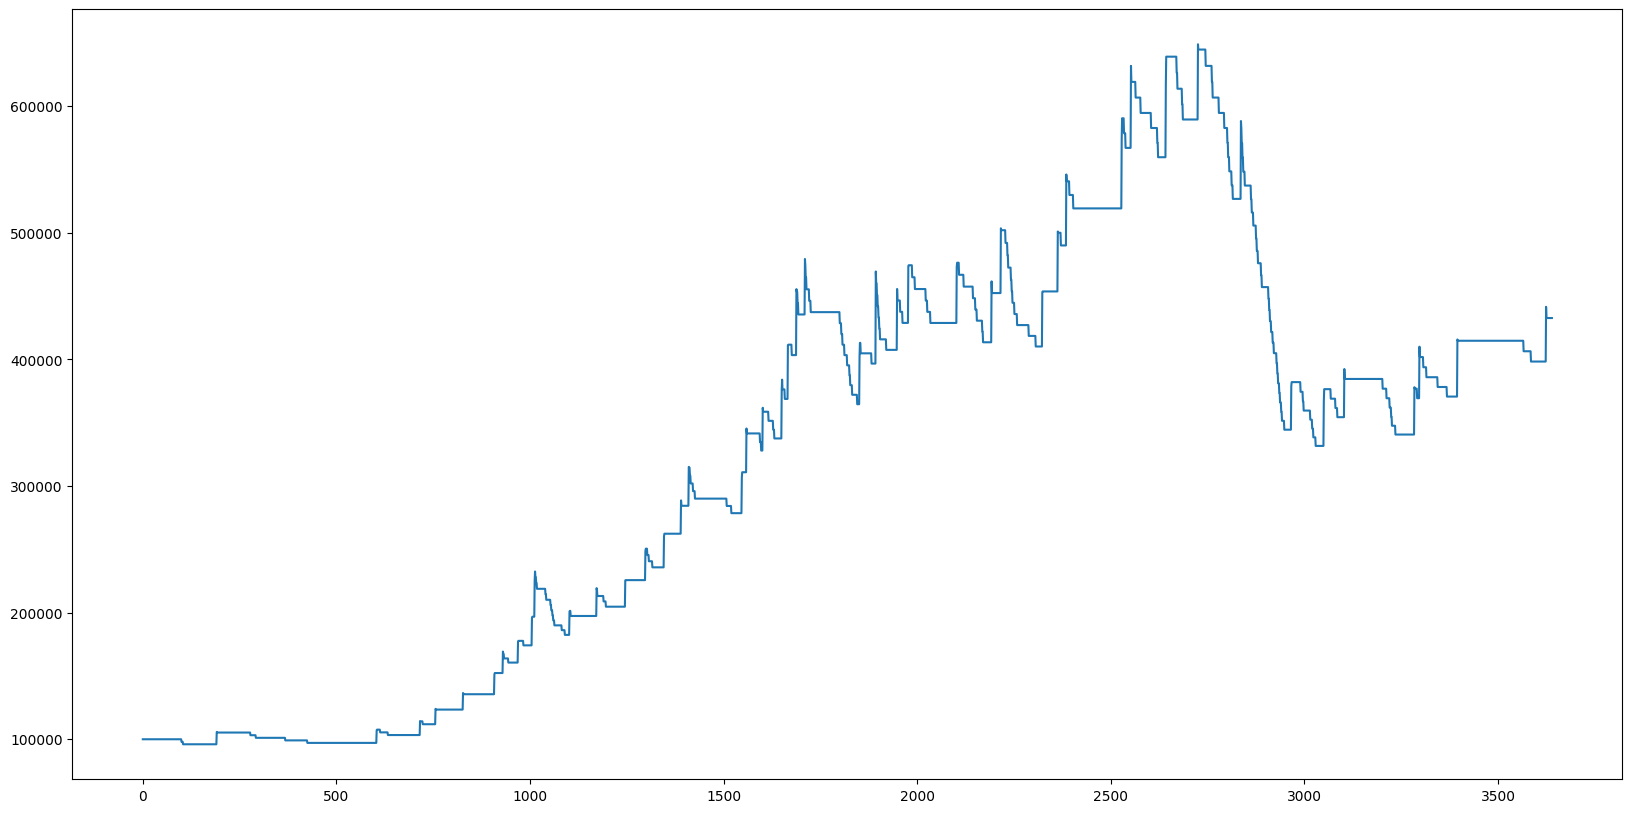

In [ ]:
# シミュレーションの推移
fig = plt.figure(figsize=(20,10))
plt.plot(result_history)
plt.show()

In [ ]:
import csv
import os
header = ['unitsRNN', 'learning_rate', 'batch_size', 'maxlen', 'result']
reserch_file_path = "/home/etherpoc/workspace/trading-fx/src/ML/research_data.csv"
if not os.path.exists(reserch_file_path):
    with open(reserch_file_path, "w") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        
with open(reserch_file_path, "a") as f:
    writer = csv.writer(f)
    writer.writerow([unitsRNN, learning_rate, batch_size, maxlen, total/first])

In [ ]:
# # 保存先がなければ作成
# dir_path = f"../models"
# dir = Path(dir_path)
# dir.mkdir(parents=True, exist_ok=True)
# # 現在の日時をつけて保存
# today = datetime.now()
# file_name = today.strftime("%Y%m%d_%H%M%S")
# model.save(f"{dir_path}/model{unitsRNN}_{maxlen}_{file_name}.h5")

In [1]:
# パッケージ
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, SimpleRNN, GRU
from keras import optimizers
from keras.callbacks import EarlyStopping

2023-06-07 23:01:48.222585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 23:01:48.827654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
for unitsRNN in [90, 120]:
    for maxlen in [30, 60, 90, 120]:
        for learning_rate in [0.0001, 0.001]:
            target_data = pd.read_csv("/home/etherpoc/workspace/trading-fx/src/ML/target/target_USDJPY_SP1.csv")
            #----OPTIONS----
            #unitsRNN      = 240
            # learning_rate = 0.0001
            patience      = 10
            epochs        = 2000
            batch_size    = 30
            #maxlen = 240
            '''
            1. データの準備
            '''

            # x = [target_data["deviation_rate"][i:i+maxlen].values for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen)]
            x = []
            for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen):
                d = []
                h = []
                l = []
                for j in range(maxlen):
                    d.append(target_data["deviation_rate"].values[i+j])
                    h.append(target_data["high"].values[i+j]/target_data["open"].values[i+j])
                    l.append(target_data["low"].values[i+j]/target_data["open"].values[i+j])
                ilist = pd.DataFrame(data={
                    "deviation_rate": d,
                    "high": h,
                    "low": l
                })
                x.append(ilist)
            t = [ target_data["rise_rate"][i+maxlen-1] for i in range(59, len(target_data["rise_rate"].values[:])-maxlen)]

            x = np.array(x).reshape(-1, maxlen, 3)
            t = np.array(t).reshape(-1, 1)
            print(x.shape, t.shape)

            x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.2, shuffle=False)
            '''
            2. モデルの構築
            '''
            model = Sequential()
            model.add(GRU(unitsRNN, activation='tanh',
                            recurrent_activation='sigmoid',
                            kernel_initializer='he_normal',
                            recurrent_initializer='orthogonal',
                            return_sequences=True))
            model.add(Dropout(0.2))
            model.add(GRU(units=50))
            model.add(Dense(1, activation='linear'))
            model.add(Activation('tanh'))
            '''
            3. モデルの学習
            '''
            optimizer = optimizers.Adam(learning_rate=learning_rate,
                                        beta_1=0.9, beta_2=0.999, amsgrad=True)

            model.compile(optimizer=optimizer,
                        loss='mean_squared_error')

            es = EarlyStopping(monitor='val_loss',
                            patience=patience,
                            verbose=1)

            hist = model.fit(x_train, t_train,
                            epochs=epochs, batch_size=batch_size,
                            verbose=2,
                            validation_data=(x_val, t_val),callbacks=[es])
            '''
            4. モデルの評価
            '''
            indata = t
            predicted = []

            preds = model.predict(x)
            for i in range(len(preds)):
                predicted.append(preds[i])
            
            # 予測値を可視化
            fig = plt.figure(figsize=(30, 10))
            plot_length = len(predicted)
            plt.plot(range(plot_length), predicted[:plot_length],
                    color='black', linewidth=1,
                    marker='o', markersize=1, markerfacecolor='black',
                    markeredgecolor='black')
            plt.plot([0, plot_length],[0, 0], "red", linestyle='dashed')
            plt.savefig(f"./predicted_graph/unitsRNN{unitsRNN}_maxlen{maxlen}_{learning_rate}_LSTM_3.png") 
                
            # 売買シミュレーション
            #---OPTIONS---
            total   = 100000     # 初期金額
            per     = 0.1       # 1回の投資金額
            per_lot = 100000     # 1ロット当たりの通貨数
            leverage = 100        # レバレッジ(整数)
            losscut = 0.998     # ロスカットする比率
            position = None     # ポジションの状態（"Buy","Sell",None）買い,売り,無し
            position_data = None  # 現在のポジションの情報[index, 取引時価格, lot数]
            recent_position = None # 直近のポジション
            result_history = [] # シミュレーションの結果を記録
            win     = 0         # ポジションを変更したときに利益がプラスの回数
            lose    = 0         # ポジションを変更したときに利益がマイナスの回数
            tax     = 0         # 支払った税金
            lscount = 0         # ロスカットの回数
            first = total
            chart = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
            chart_high = [target_data["high"][i+maxlen-1] for i in range(59, len(target_data["high"].values[:])-maxlen)]
            chart_low = [target_data["low"][i+maxlen-1] for i in range(59, len(target_data["low"].values[:])-maxlen)]
            result = []
            for k in [0,len(predicted)-10000]:
                for i in range(k, len(predicted)):
                    flag_losscut = False
                    # ロスカット計算
                    if position in ["Buy", "Sell"]:
                        if position == "Buy":
                            if position_data[1] * losscut > chart_low[i]:
                                total -= position_data[1] * (1-losscut) * position_data[2] * per_lot
                                flag_losscut = True
                        
                        elif position == "Sell":
                            if position_data[1] * (2-losscut) < chart_high[i]:
                                total -= position_data[1] * (1-losscut) * position_data[2] * per_lot
                                flag_losscut = True
                    
                    # ロスカットがなければ取引実行
                    if not flag_losscut:
                        if position == None:
                            if predicted[i] > 0:
                                position = "Buy"
                            else:
                                position = "Sell"
                            # if predicted[i] > 0 and recent_position != "Buy":
                            #     position = "Buy"
                            # elif recent_position != "Sell":
                            #     position = "Sell"
                                
                            # 何ロット？
                            lots = (total * per * leverage / chart[i]) / per_lot
                            position_data = [i, chart[i], lots]
                                
                        elif position == "Buy":
                            if predicted[i] < 0 or (chart[i] - position_data[1])/position_data[1] > 0.01:
                                # 直前のポジションを決済
                                profit = (chart[i] - position_data[1]) * position_data[2] * per_lot
                                total += profit
                                if profit > 0:
                                    win += 1
                                else:
                                    lose += 1
                                position = "Sell"
                                # 何ロット？
                                lots = (total * per * leverage / chart[i]) / per_lot
                                position_data = [i, chart[i], lots]
                                
                        elif position == "Sell":
                            if predicted[i] > 0 or (position_data[1] - chart[i])/position_data[1] > 0.01:
                                # 直前のポジションを決済
                                profit =(position_data[1] - chart[i]) * position_data[2] * per_lot
                                total += profit
                                if profit > 0:
                                    win += 1
                                else:
                                    lose += 1
                                position = "Buy"
                                # 何ロット？
                                lots = (total * per * leverage / chart[i]) / per_lot
                                position_data = [i, chart[i], lots]
                        else:
                            print(ValueError)
                    else:
                        recent_position = position
                        position = None
                        lose += 1
                        lscount += 1
                    
                    # 記録
                    result_history.append(total)

                print(f"勝利：{win}")
                print(f"敗北：{lose}, ロスカット{lscount}")
                print(f"最終金額：{total}")
                print(f"最終倍率：{total/first}")
                result.append({
                    'win_lose': win/lose,
                    'result': total/first,
                })
            # 保存先がなければ作成
            dir_path = f"../models"
            dir = Path(dir_path)
            dir.mkdir(parents=True, exist_ok=True)
            # 現在の日時をつけて保存
            today = datetime.now()
            file_name = today.strftime("%Y%m%d_%H%M%S")
            model.save(f"{dir_path}/model{unitsRNN}_{maxlen}_{learning_rate}_{file_name}.h5")
            del model
            import csv
            import os
            header = ['unitsRNN', 'learning_rate', 'maxlen', 'result_10000', 'win/lose', 'result_all', 'win/lose', 'type', 'file_name']
            reserch_file_path = "/home/etherpoc/workspace/trading-fx/src/ML/research_data_LSTML.csv"
            if not os.path.exists(reserch_file_path):
                with open(reserch_file_path, "w") as f:
                    writer = csv.writer(f)
                    writer.writerow(header)
                    
            with open(reserch_file_path, "a") as f:
                writer = csv.writer(f)
                writer.writerow([unitsRNN, learning_rate, maxlen, result[0]['result'], result[0]['win_lose'], result[1]['result'], result[1]['win_lose'], "GRU", file_name])

KeyboardInterrupt: 